# Improving Results of CNN Network With Data Augmentation

**Import libs/dependencies**

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Get dataset to test model on
Note data used is a dataset of [flowers](https://www.tensorflow.org/tutorials/load_data/images)

In [75]:
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, cache_dir='.', untar=True)

**Or upload pre-downloaded dataset**

Note: Need to upload to google drive or access the file locally by first ounting google drive

In [76]:
# # note that this code was executed in google colab and the dataset to be used was downloaded 
# # and saved in a folder synced with gdrive
# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = "drive/Othercomputers/My MacBook Air/DeepLearningCNN/datasets/flower_photos/"

**Conversion and work with path objects**

In [77]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

**Test pathlib use and display image**

datasets/flower_photos/roses/5777669976_a205f61e5b.jpg


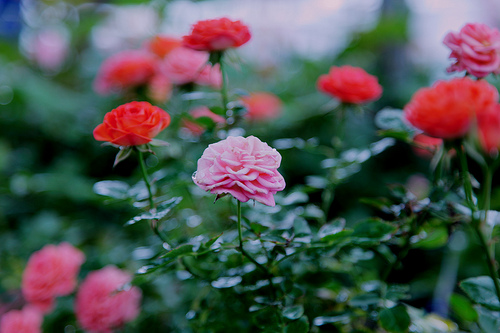

In [78]:
roses = list(data_dir.glob('roses/*'))
print(str(roses[0]))
PIL.Image.open(roses[0])

## Group images based on flower type & define labels

In [79]:
flowers = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'tulips': list(data_dir.glob('tulips/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*'))
}

**Define labels**

In [80]:
flowers_labels = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'tulips': 3,
    'sunflowers': 4

}
classes = {
    0: 'roses',
    1: 'daisy',
    2: 'dandelion',
    3: 'tulips',
    4: 'sunflowers'
}

## Reshaping images size

**Initialise shape of image**

In [81]:
IMAGE_SHAPE = (180,180)

In [82]:
X, y = [], []
for flower_name, images in flowers.items():
  for image in images:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img, IMAGE_SHAPE)
    X.append(resized_img)
    y.append(flowers_labels[flower_name])

In [83]:
# normalisation
X = np.array(X)
y = np.array(y)
X = X / 255

## Get test & train dataset

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Set up basic model and train (unaugmented data)

In [12]:
cnn = Sequential([
                  layers.Conv2D(16, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Flatten(),
                  layers.Dense(128, activation='relu'),
                  layers.Dense(5, activation='softmax')
])

cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn.fit(X_train, y_train, epochs = 30)

Epoch 1/30
86/86 [==============================] - 12s 16ms/step - loss: 1.3624 - accuracy: 0.4132
Epoch 2/30
86/86 [==============================] - 1s 16ms/step - loss: 1.0047 - accuracy: 0.5956
Epoch 3/30
86/86 [==============================] - 1s 16ms/step - loss: 0.8414 - accuracy: 0.6759
Epoch 4/30
86/86 [==============================] - 1s 16ms/step - loss: 0.6295 - accuracy: 0.7565
Epoch 5/30
86/86 [==============================] - 1s 16ms/step - loss: 0.4524 - accuracy: 0.8459
Epoch 6/30
86/86 [==============================] - 1s 16ms/step - loss: 0.2314 - accuracy: 0.9215
Epoch 7/30
86/86 [==============================] - 1s 16ms/step - loss: 0.1557 - accuracy: 0.9477
Epoch 8/30
86/86 [==============================] - 1s 16ms/step - loss: 0.0907 - accuracy: 0.9717
Epoch 9/30
86/86 [==============================] - 1s 16ms/step - loss: 0.0618 - accuracy: 0.9833
Epoch 10/30
86/86 [==============================] - 1s 16ms/step - loss: 0.0332 - accuracy: 0.9935
Epoch 11

## Evaluate Model

In [13]:
cnn.evaluate(X_test, y_test)

29/29 [==============================] - 1s 11ms/step - loss: 2.5229 - accuracy: 0.6449


[2.522942304611206, 0.6448801755905151]

## Overfitting

There are clear signs of overfitting in the model. Accuracy on the training dataset is close to 1 whereas on the test set, its < 0.65

## Data Augmentation

**Define custom plot function**

For viewing of images represented in numpy matrix form

In [85]:
# X - List of images
# y - List of corresponding result labels
# index - display the image at the specified index

def plot(X, y, idx):
  plt.imshow(X[idx])
  ax = plt.gca()
  ax.axes.xaxis.set_ticklabels([])
  ax.axes.yaxis.set_ticklabels([])
  plt.xlabel(classes[y[idx]])

**Augment dataset**

Introduce preprocessing layers to augment image features before passing through data encoding the images through the network.

See [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) for the list of Tensorflow's image augmentation.

In [86]:
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal",
                                                                                   input_shape=(180,
                                                                                                180,
                                                                                                3)),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
                                      layers.experimental.preprocessing.RandomContrast(0.2),
                                      layers.experimental.preprocessing.RandomRotation(0.3)
                                      
])

**View a sample of an augmented data**

Showing unaugmented image: 


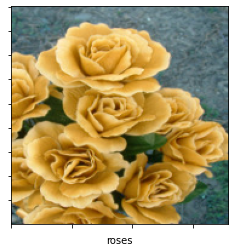

In [87]:
print("Showing unaugmented image: ")
plot(X_train, y_train, 5)

Now showing augmented: 


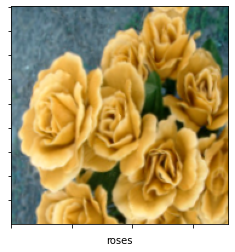

In [90]:
print("Now showing augmented: ")
plot(data_augmentation(X_train), y_train, 5)

## Set up model and train (with augmented data)

**Apply data augmentation to the same model set-up as before**

In [91]:
cnn = Sequential([
                  data_augmentation,
                  layers.Conv2D(16, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation = 'relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(128, activation='relu'),
                  layers.Dense(5, activation='softmax')
])

cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn.fit(X_train, y_train, epochs = 30)

Epoch 1/30
86/86 [==============================] - 3s 19ms/step - loss: 1.4360 - accuracy: 0.3641
Epoch 2/30
86/86 [==============================] - 2s 19ms/step - loss: 1.1207 - accuracy: 0.5338
Epoch 3/30
86/86 [==============================] - 2s 19ms/step - loss: 1.0515 - accuracy: 0.5741
Epoch 4/30
86/86 [==============================] - 2s 19ms/step - loss: 0.9793 - accuracy: 0.6141
Epoch 5/30
86/86 [==============================] - 2s 22ms/step - loss: 0.9319 - accuracy: 0.6261
Epoch 6/30
86/86 [==============================] - 2s 21ms/step - loss: 0.9018 - accuracy: 0.6446
Epoch 7/30
86/86 [==============================] - 2s 19ms/step - loss: 0.8456 - accuracy: 0.6711
Epoch 8/30
86/86 [==============================] - 2s 19ms/step - loss: 0.8544 - accuracy: 0.6653
Epoch 9/30
86/86 [==============================] - 2s 19ms/step - loss: 0.8112 - accuracy: 0.6824
Epoch 10/30
86/86 [==============================] - 2s 19ms/step - loss: 0.7718 - accuracy: 0.6893
Epoch 11/

## Evaluate Model

**Observe improved results**

Accuracy on test set improved by 0.1 (0.64 -> 0.74). This can be further improved by experimenting further with data augmentation to expand training examples (more training + regularization.

Note: It seems the network can be further improved with more training epochs as well as the accuracy on the training set does not seem to have plateued yet unlike in the previous network with unaugmented dataset.

In [92]:
cnn.evaluate(X_test, y_test) 

29/29 [==============================] - 0s 10ms/step - loss: 0.6978 - accuracy: 0.7484


[0.6978164315223694, 0.7483659982681274]